In [2]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2 as cv

from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    InterpolationMode,
)

The idea of this notebook is to create a folder with lesions images, ready to be used for Dreambooth generation.

- Question 1. Where is the infromation containing the bounding box of the images?
    - Answer: In the metadata file, the breast40k_RGB

[  19 1157  323 1508]


True

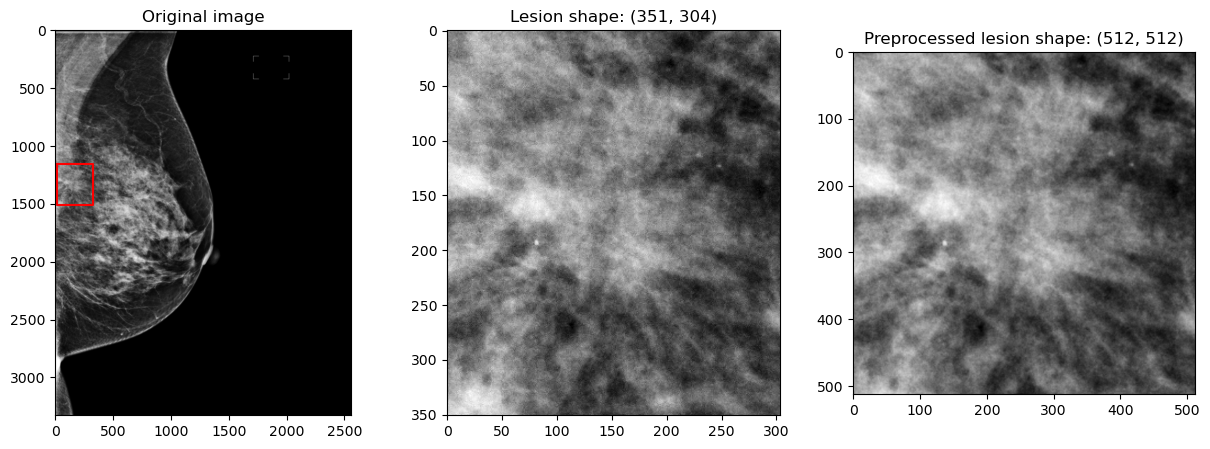

In [4]:
folder_name = 'breast40k'
resolution = 512

# paths
metadata_path = repo_path / 'data/metadata'/f'{folder_name}_RGB.csv'
imageFolder_path = repo_path / 'data/images'/folder_name
# Read metadata file
metadata = pd.read_csv(metadata_path)
# filter only images with marks
metadata = metadata[metadata['marks'] == True]
metadata = metadata.reset_index(drop=True)


###### LOOP
# get the first row
row = metadata.iloc[0]
# get the path to the image
image_path = imageFolder_path / str(row['image_id'] + '.png')
side = row['image_laterality']
# read image using PIL
image = Image.open(image_path)
image = np.array(image)
# get the coordinates of the lesion
bbox = row['bbox']
bbox = bbox.replace('(', '').replace(')', '').split(',')
x1, y1, x2, y2 = [int(i) for i in bbox]
coord = np.asarray([x1, y1, x2, y2])
print(coord)
# if side is right, flip x coordinate
if side == 'R':
    coord[0] =  image.shape[1] - coord[0]# -1
    coord[2] =  image.shape[1] - coord[2]# -1
    # switch x coordinates
    coord[[0, 2]] = coord[[2, 0]]        
    print(f'Flipped coordinates: {coord}')

if np.any(coord < 0) or (coord[0]-coord[2]) == 0:
        print('Bad image')
# crop the image
lesion = image[coord[1]:coord[3], coord[0]:coord[2]]
# show the image and the lesion next to it
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
# plot bbox on the image
ax[0].plot(coord[[0, 2, 2, 0, 0]], coord[[1, 1, 3, 3, 1]], 'r')
ax[1].imshow(lesion, cmap='gray')
ax[1].set_title(f'Lesion shape: {lesion.shape}')

# Transforming to pil image format allows for cropping and resizing using Pytorch

preprocess = Compose(
    [ # classic squared aspect-preserved centered image
        Resize(resolution, interpolation= InterpolationMode.BILINEAR),
        CenterCrop(resolution), 
    ]
)

# transform lesion to pil image
lesion_pil = Image.fromarray(lesion)
preprocessed_lesion = preprocess(lesion_pil)
# back to array
preprocessed_lesion = np.array(preprocessed_lesion)
# show the preprocessed lesion
ax[2].imshow(preprocessed_lesion, cmap='gray')
ax[2].set_title(f'Preprocessed lesion shape: {preprocessed_lesion.shape}')

# scale to 0-255 and convert to uint8
im_uint8 = (preprocessed_lesion/ 4095.0)*255.0
im_uint8 = im_uint8.astype(np.uint8)
# convert to RGB
im_RGB = np.stack((im_uint8,)*3, axis=-1)
# save as png
# cv.imwrite(str('ex.png'), im_RGB)